# Preprocessing

In [1]:
# NLTK, stands for Natural Language Toolkit, is a library for English punctuations, statistics, and NLP
# NLTK contains 100 words like I, my, me, over, postposition, suffix, but not needed/necessary for abstraction
# use NLTK to remove stopwords from dataset
import nltk
nltk.download('stopwords')
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
import urllib.request
import numpy as np
import pandas as pd
import os, re
import matplotlib.pyplot as plt
import requests
import summa

from summa.summarizer import summarize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# load data from url
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.head()
# 이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

# 추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요.
# 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [4]:
# slicing to use only text and summary cols
data = data[['headlines','text']]
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [5]:
# print 15 random samples
data.sample(15)

,headlines,text
31103,Deadpool actor goes on South Korean show disgu...,"Actor Ryan Reynolds, who portrays the superher..."
82014,Lalu Yadav is Bihar's Robert Vadra: BJP's Sush...,BJP leader Sushil Modi on Wednesday called RJD...
56971,Ready to support Pakistan in eliminating terro...,Russian Foreign Minister Sergey Lavrov on Mond...
73529,Smartphone maker HTC considers selling itself:...,Taiwanese smartphone manufacturer HTC has repo...
75569,Will try utmost to strike a fine balance: Cens...,Newly inducted Censor Board chief Prasoon Josh...
16443,30-week pregnant woman allowed abortion over f...,"Bombay High Court has allowed a woman, who is ..."
59585,FSSAI to curb misleading ads claiming food ite...,The Food Safety and Standards Authority of Ind...
12899,Punjab to give Ã¢ÂÂ¹5L to family of each dead...,Punjab CM Captain Amarinder Singh has announce...
41740,Being successful is a double-edged sword: Varu...,Actor Varun Dhawan has said being successful i...
4028,Full marks to Bharat Arun: Shastri praises bow...,Praising the Indian cricket team's bowling coa...


In [6]:
# pandas.DataFrame.nunique: count num of unique elements
# checking for duplicates
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [7]:
# use drop_duplicates to remove any duplicates
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [8]:
# check for any null vals
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [9]:
# dropna to remove any null vals rows
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [10]:
# dictionary for text normalization
# text normalization: process of transforming text into a single canonical form that it might not have had before
# canonical form: standard way of presenting that object as a mathematical expression
# mathematical expression: finite combination of symbols that is well-formed according to rules that depend on the context
# contraction: words or combinations of words that are shortened by dropping letters and
# replacing them by an apostrophe, and removing them contributes to text standardization
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
               "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
               "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
               "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
               "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
               "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
               "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
               "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
               "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
               "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
               "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
               "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
               "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
               "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
               "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
               "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
               "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
               "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
               "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
               "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
               "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
               "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
               "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [11]:
# 일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들이 존재해요.
# 이를 불용어(stopwords)라고 불러요. 때로는 불용어를 제거하는 것이 자연어 처리의 성능을 높이는 방법일 수 있어요.
# 여기서는 NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거할 거예요.
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [12]:
# 모든 영어 문자는 소문자로 만들고, 섞여있는 html 태그를 제거하고,
# 정규 표현식을 통해 각종 특수문자를 제거해서 정말 필요한 내용만 잘 학습할 수 있도록 처리할 거예요.

# 함수의 하단을 보면, NLTK를 이용해 불용어를 제거하는 파트가 있는데,
# 이는 Text 전처리 시에서만 호출하고 이미 상대적으로 문장 길이가 짧은 Summary 전처리할 때는 호출하지 않을 예정이에요.
# Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 Summary에는 남아 있는 게 더 좋을 것 같습니다.
# 이 처리를 위해서 함수의 인자로 remove_stopwords를 추가하고, if문을 추가했어요.
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [13]:
# 전처리 전, 후의 결과를 확인하기 위해서 임의의 text와 summary를 만들어 함수를 호출해 볼까요.
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


In [14]:
# 결과를 보면 기본적으로 모든 알파벳이 소문자로 변환되고, <br />과 같은 html 태그가 제거되었죠.
# (or finish)와 같은 괄호로 묶였던 단어 시퀀스가 제거된 것도 확인할 수 있어요. 또한 특수문자가 제거되면서 영어만 남았어요.

# 이제 함수가 잘 작동하는 것을 확인했으니, 훈련 데이터 전체에 대해서 전처리를 수행해볼게요.
# 이때, Text의 경우에는 불용어를 제거하고, Summary의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행해야 해요.
# 먼저 Text를 전처리하고, 결과를 확인하기 위해서 상위 5개의 줄을 출력해볼게요.
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [15]:
# 이제 Summary에 대해서 전처리 함수를 호출해 줄 때는, 불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 False를 넣어줄게요.
clean_headlines = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("Headlines 전처리 후 결과: ", clean_headlines[:5])

Headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [16]:
# 이렇게 텍스트 정제의 과정을 거친 후에는 다시 한번 빈(empty) 샘플이 생겼는지 확인해보는 것이 좋아요.
# 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있어요.
# 이렇게 되면 샘플 자체가 빈 값을 가지게 되겠죠.

# 보다 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장할게요.
# 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체해요.

data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [17]:
# 이전과 같이 .isnull().sum()을 사용해서 Null 값이 생겼는지 해볼게요.
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [18]:
# Summary 열에서 70개의 Null 값이 생겼네요.
# 원래는 단어가 있었는데, 정제 과정에서 모든 단어가 제거되어 빈 샘플이 70개나 생겼다는 의미예요. 이 샘플들은 모두 제거해줄게요.

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


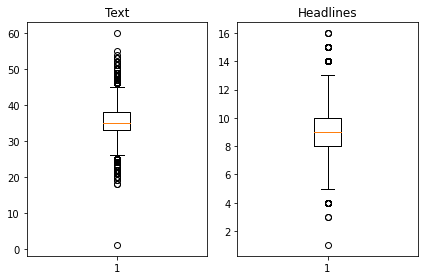

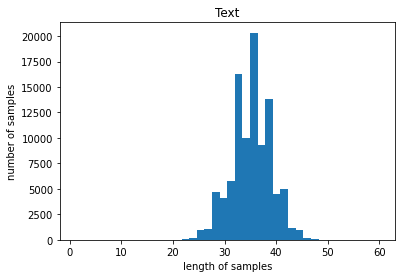

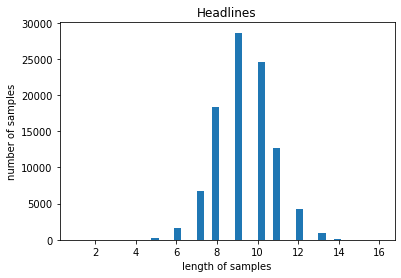

In [19]:
# 필요 없는 단어를 모두 솎아낸 데이터를 가지게 되었으니, 이제 훈련에 사용할 샘플의 최대 길이를 정해줄 차례에요.

# Text와 Headlines의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해서 볼게요.
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
# 이로부터 Text의 최대 길이와 Summary의 적절한 최대 길이를 임의로 정해볼게요.
text_max_len = 50
headlines_max_len = 8

In [21]:
# 각각 50과 8로 정했는데 이 길이를 선택했을 때,
# 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하는 편이 객관적으로 길이를 결정하는 데 도움이 될거예요.
# 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단해볼게요.
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [22]:
# 이렇게 만든 함수를 Text와 Summary에 적용해 우리가 결정한 임의의 길이가 몇%의 샘플까지 포함하는지 볼 수 있겠죠.
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.2755693371289142


In [23]:
# 각각 50과 8로 패딩을 하게 되면 해당 길이보다 긴 샘플들은 내용이 잘리게 되는데,
# Text 열의 경우에는 약 23%의 샘플들이 내용이 망가지게 된다고 하네요.

# 우리는 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제할게요.
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 27105


In [24]:
# seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있어요.
# 이번 실습에서는 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가할 거예요.
# 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input,
# 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 이름을 정했어요.
# 두 개의 문장 모두 Summary 열로부터 만들 거예요.
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
19,odisha cm patnaik controls mining mafia union ...,union minister dharmendra pradhan wednesday cl...,sostoken odisha cm patnaik controls mining maf...,odisha cm patnaik controls mining mafia union ...
21,isro unveils bengaluru centre for manned space...,indian space research organisation wednesday u...,sostoken isro unveils bengaluru centre for man...,isro unveils bengaluru centre for manned space...
22,killed injured in saudi arabia floods,least people killed others injured saudi arabi...,sostoken killed injured in saudi arabia floods,killed injured in saudi arabia floods eostoken
29,seat cushions from missing plane carrying foot...,investigators searching lost plane carrying ar...,sostoken seat cushions from missing plane carr...,seat cushions from missing plane carrying foot...
36,agustawestland scam accused rajiv saxena extra...,agustawestland chopper scam co accused rajiv s...,sostoken agustawestland scam accused rajiv sax...,agustawestland scam accused rajiv saxena extra...


In [25]:
# 앞뒤로 토큰이 잘 붙었죠? 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장해 줄게요.
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [26]:
# 이제 훈련 데이터와 테스트 데이터를 분리할거에요.

# 훈련 데이터와 테스트 데이터를 분리하는 방법은 분리 패키지를 사용하는 방법,
# 또는 직접 코딩을 통해서 분리하는 방법 등 여러 가지 방법이 있을 텐데 여기서는 직접 해볼게요.
# 우선, encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어줄게요.
indices = np.arange(encoder_input.shape[0]) # indices = np.arange(27105)
np.random.shuffle(indices) # shuffle 27105
print(encoder_input[0])
print(encoder_input.shape[0])
print(indices)

union minister dharmendra pradhan wednesday claimed illegal mining mafia odisha operates control cm naveen patnaik state congress chief niranjan patnaik added time come people odisha put full stop activities time come us ask explanation corrupt government
27105
[11804  4067 23945 ... 16125  5231 25073]


In [27]:
# 이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 되겠죠.
print('pre', encoder_input)
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print()
print('post', encoder_input)

pre ['union minister dharmendra pradhan wednesday claimed illegal mining mafia odisha operates control cm naveen patnaik state congress chief niranjan patnaik added time come people odisha put full stop activities time come us ask explanation corrupt government'
 'indian space research organisation wednesday unveiled human space flight centre bengaluru crore manned space mission gaganyaan scheduled isro said centre responsible development engineering systems crew survival space crew selection training also pursue activities sustained human space flight missions isro added'
 'least people killed others injured saudi arabia week due flooding heavy rain emergency services rescued people flooded areas half tabuk heavy rains hit mainly western northwestern parts saudi arabia near border jordan'
 ...
 'pakistan started building nearly kilometer fence along border afghanistan according reports comes afghan militants reportedly killed six pakistani soldiers stationed security checkpoints earli

In [28]:
# 이제 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리해 줄게요.
# 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의해 줄게요.
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 5421


In [29]:
# 이렇게 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분할게요. :표시의 위치에 주의해 주세요.
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 21684
훈련 레이블의 개수 : 21684
테스트 데이터의 개수 : 5421
테스트 레이블의 개수 : 5421


In [30]:
# Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있어요.
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [31]:
# 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요.
# src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있어요.

threshold = 5
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# encoder_input_train에는 3만여 개의 단어가 있네요. 그 아래의 통계 정보들을 해석해볼까요?

# 등장 빈도가 threshold 값인 7회 미만, 즉 6회 이하인 단어들은 단어 집합에서 무려 70% 이상을 차지하네요.
# 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.39%밖에 되지 않아요.

단어 집합(vocabulary)의 크기 : 42574
등장 빈도가 4번 이하인 희귀 단어의 수: 28007
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 14567
단어 집합에서 희귀 단어의 비율: 65.78428148635317
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.284425554061674


In [32]:
# 그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 합니다.
# 위에서 이를 제외한 단어 집합의 크기를 8천여 개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 8,000으로 제한해볼게요.
# 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있어요.
src_vocab = 14000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [33]:
# texts_to_sequences는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행해요.
# 현재 단어 집합의 크기를 8,000으로 제한했으니까 이제 8,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않아요.

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[11762, 181, 797, 55, 57, 563, 2823, 1789, 5573, 3075, 5573, 3190, 13018, 797, 1, 20, 1923, 148, 5388, 1809, 1015, 322, 833, 708, 1833, 3617, 5573, 1810, 579, 3861, 1811, 322], [980, 15, 6212, 60, 4523, 53, 14, 2188, 49, 11763, 216, 1196, 648, 4917, 1167, 1167, 2915, 3770, 19, 2021, 3330, 44, 1339, 580, 1, 1465, 802, 166, 2188, 6213, 1040, 507], [5, 86, 179, 187, 551, 4771, 4644, 1975, 1790, 384, 10782, 10782, 2694, 1068, 319, 99, 21, 337, 1116, 161, 1399, 8721, 2694, 699, 6459, 5055, 4771, 1, 727, 20, 2694]]


In [34]:
# Summary 데이터에 대해서도 동일한 작업을 수행할게요.
# 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산해요.
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [35]:
# 이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요. 이는 tar_tokenizer.word_index에 저장되어 있어요.
# tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데,
# 이를 통해서 통계적인 정보를 얻어서, 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요.
threshold = 3
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 18938
등장 빈도가 2번 이하인 희귀 단어의 수: 10906
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8032
단어 집합에서 희귀 단어의 비율: 57.58791847079945
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.403472054522525


In [36]:
# 등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 77%를 차지하고 있네요.
# 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 5.87%밖에 되지 않아요.
# 아까 했던 것과 동일하게 이 단어들은 모두 제거할게요. 어림잡아 2,000을 단어 집합의 크기로 제한할게요.
tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 179, 790, 4, 1809, 5, 5363, 3, 5364], [1, 14, 3029, 4644, 4, 24, 1620], [1, 609, 4100, 2192, 989, 89, 521, 4, 1455], [1, 2193, 1456, 190, 646, 3695, 3, 91], [1, 685, 2194, 104, 1333, 1113, 6, 107, 3]]
target
decoder  [[179, 790, 4, 1809, 5, 5363, 3, 5364, 2], [14, 3029, 4644, 4, 24, 1620, 2], [609, 4100, 2192, 989, 89, 521, 4, 1455, 2], [2193, 1456, 190, 646, 3695, 3, 91, 2], [685, 2194, 104, 1333, 1113, 6, 107, 3, 2]]


In [37]:
# 정상적으로 정수 인코딩 작업이 끝났어요.
# 현재 decoder_input_train과 decoder_target_train에는 더 이상 숫자 2,000이 넘는 숫자들은 존재하지 않아요.
# 그런데 다음 작업인 패딩 하기로 넘어가기 전에 한 가지 점검해야 할 것이 있어요.

# 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은
# 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있어요.
# 이 현상은 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만,
# 애초에 평균 길이가 4밖에 되지 않았던 요약문(Summary)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높겠죠.

# 요약문에서 길이가 0이 된 샘플들의 인덱스를 받아와볼게요.
# 여기서 주의할 점은 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고,
# 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않아요.
# 그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나올 거예요.
# 길이가 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있을 테니까요.

# 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장해볼게요.
# 이 샘플들은 모두 삭제할 거예요.


drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 21684
훈련 레이블의 개수 : 21684
테스트 데이터의 개수 : 5421
테스트 레이블의 개수 : 5421


In [38]:
# add padding sequence
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

In [39]:
# 이제는 모델을 설계할 시간이에요. 우선 함수형 API를 이용해서 인코더를 설계해 볼게요.

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# 임베딩 벡터의 차원은 128로 정의하고, hidden state의 크기를 256으로 정의했어요.
# hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터에요.
# 이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수라고 이해하면 돼요.
# 다른 신경망과 마찬가지로, 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아니에요.

# 인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였어요.
# hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있죠.
# 3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내줘야겠죠?

# 또한 LSTM은 dropout 뿐 아니라 recurrent dropout까지 사용할 수 있어요.
# 일반적인 dropout은 레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 해결해주는 방법이에요.

# 반면 recurrent dropout은 dropout을 레이어가 아닌 time step마다 해주는 방식이에요.
# 즉 time step의 입력을 랜덤으로 생략해 주는 거죠.
# recurrent dropout은 일반적인 dropout와 같이 regularization을 해주는 효과가 있고, 과적합을 방지할 수 있다고 해요.

# 아래 그림은 일반적인 dropout과, dropout과 recurrent dropout을 동시에 사용한 것을 시각적으로 표현한 것입니다.
# 색이 있는 화살표는 dropout을 나타낸 것이에요.
# (색이 다른 것은 다른 dropout mask를 사용했다는 표시인데, 지금은 그냥 넘어가셔도 됩니다.)
# 코드를 수정해서 LSTM에 dropout과 recurrent dropout을 모두 사용할 수 있습니다.그렇게 되면 오른쪽 그림과 같은 형태가 되겠군요.
# 참고로 dropout과 recurrent dropout을 모두 사용한 것을 Variational Dropout이라고도 해요.

# recurrent dropout을 사용할 시 cuDNN을 사용할 수 없어서 recurrent dropout을 사용하지 않을 때보다 학습 시간이 오래 걸립니다.

In [40]:
# 이제 디코더를 설계해볼게요!

# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [41]:
# 디코더의 출력층을 설계해볼게요.

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1792000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [42]:
# 아래와 같이 어텐션 층을 만들고, 위에서 설계한 디코더의 출력층을 수정해 봅시다.

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1792000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [43]:
# compile and train model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
85/85 [==============================] - 67s 678ms/step - loss: 6.8399 - val_loss: 6.3102
Epoch 2/50
85/85 [==============================] - 57s 668ms/step - loss: 6.3629 - val_loss: 6.0382
Epoch 3/50
85/85 [==============================] - 57s 667ms/step - loss: 6.1213 - val_loss: 5.9384
Epoch 4/50
85/85 [==============================] - 57s 667ms/step - loss: 5.9497 - val_loss: 5.8120
Epoch 5/50
85/85 [==============================] - 56s 661ms/step - loss: 5.7853 - val_loss: 5.6899
Epoch 6/50
85/85 [==============================] - 57s 669ms/step - loss: 5.6188 - val_loss: 5.6312
Epoch 7/50
85/85 [==============================] - 57s 666ms/step - loss: 5.4409 - val_loss: 5.4882
Epoch 8/50
85/85 [==============================] - 56s 664ms/step - loss: 5.2584 - val_loss: 5.3562
Epoch 9/50
85/85 [==============================] - 57s 665ms/step - loss: 5.0883 - val_loss: 5.2860
Epoch 10/50
85/85 [==============================] - 57s 667ms/step - loss: 4.9325 - val_lo

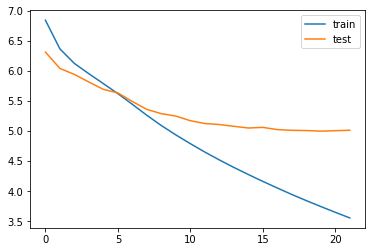

In [44]:
# 이제 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화 해봐요.
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [45]:
# 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로,
# 필요한 3개의 사전을 아래와 같이 미리 준비해 둡니다.
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [46]:
# seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다는 것, 알고 계시나요?

# 훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로,
# 인코더와 디코더를 엮은 통짜 모델 하나만 준비했습니다.

# 그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에
# 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [47]:
# 어텐션 메커니즘을 사용하는 출력층을 설계해 주세요.

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [48]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들어주세요.

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [49]:
# 테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하겠죠.
# 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어볼게요.
# 함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고
# Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만들 거예요.

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [85]:
# 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교해보세요.
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("추출 요약 :", summarize(data['text'].iloc[i], ratio=1))
    print("\n")
    
# 많은 결과가 출력이 되는데, 기존의 요약과는 다른 요약을 출력하면서도 원문의 내용을 담고 있는 의미 있는 요약들이 보이네요.
# 심지어 일부 요약의 경우에는 원문에 없던 단어를 사용해서 요약을 하기도 하고 있어요.
# 워드 임베딩과 RNN의 콜라보로 이뤄낸 신기한 성과네요!

# 물론 슬프게도 그다지 좋지 않은 요약의 예도 꽤나 보이기도 하네요.
# 성능을 개선하기 위해서는 seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법도 있고,
# 빔 서치(beam search), 사전 훈련된 워드 임베딩(pre-trained word embedding),
# 또는 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)와 같은 여러 개선 방안들이 존재합니다.
# 이런 방안들에 대해서도 향후 살펴보게 될 것입니다.

원문 : least eight people injured sunday small iron bridge collapsed near maharashtra district injured admitted hospital treatment incident happened villagers passing bridge reach crematorium near river reports said 
실제 요약 : injured as bridge collapses in maharashtra 
예측 요약 :  dead injured after boat collapses in
추출 요약 : 


원문 : mizoram congress mla showed increase assets mla five years shown immovable assets lakh showed assets crore legislator called saying include details crore residence 
실제 요약 : mla assets grow in yrs calls it 
예측 요약 :  congress mlas demands into congress mlas
추출 요약 : 


원문 : pakistani pacer hasan ali top ranked bowler odis celebrates wickets mimicking bomb explosion ali highest wicket taker year wickets matches mechanism leads blast claiming victims ali said one childhood dreams top ranked bowler 
실제 요약 : pakistani bowler mimics bomb explosion on taking wicket 
예측 요약 :  india beat pakistan of champions trophy
추출 요약 : 


원문 : facebook ceo mark zuckerberg plans integra

예측 요약 :  world longest dies in china
추출 요약 : 


원문 : former indian captain sunil gavaskar said according former captain ms dhoni play domestic cricket whenever gets opportunity gavaskar said dhoni playing limited overs domestic cricket also four day domestic cricket play four day game great feet gavaskar added 
실제 요약 : ms dhoni should play domestic cricket gavaskar 
예측 요약 :  dhoni has dhoni in cricket cricket
추출 요약 : 


원문 : india men archery team gold medal men compound event asia cup stage bangkok saturday third seeded trio robert singh saini top seeded iran final champions meanwhile india women team silver competition 
실제 요약 : india wins team gold at asia cup 
예측 요약 :  india wins world first web
추출 요약 : 


원문 : union health minister jp nadda presented new mental healthcare bill lok sabha attempted suicide since person step extreme mental stress means triggered mental illness minister said features bill include banning electric shock therapy mentally ill children 
실제 요약 : health mini

예측 요약 :  dept raids probe for lakh lakh
추출 요약 : 


원문 : kerala government temporarily banned trekking forest areas nine people killed forest fire trekking hills tamil nadu state forest department also directed take necessary prevent forest fires tour operators directed undertake activities 
실제 요약 : kerala temporarily bans after tn fire kills 
예측 요약 :  maharashtra police to get liquor
추출 요약 : 


원문 : one man commission set tamil nadu government circumstances leading hospitalisation late cm jayalalithaa assumed charge friday assuming office commission headed retired high court justice would followed notification calling information agenda one man inquiry commission 
실제 요약 : commission into jayalalithaa death takes charge 
예측 요약 :  iit nadu hc gets online marriage
추출 요약 : 


원문 : flyover bengaluru outer ring road construction eight years construction flyover completed within months commencement work flyover taken bangalore development authority halted owing problems land acquisition 
실제 요

# Extractive Summarization

In [88]:
# 매트릭스 시놉시스를 다운로드 해주세요.
data = pd.read_csv('news_summary_more.csv')
text = data['text']
text

0        Saurav Kant, an alumnus of upGrad and IIIT-B's...
1        Kunal Shah's credit card bill payment platform...
2        New Zealand defeated India by 8 wickets in the...
3        With Aegon Life iTerm Insurance plan, customer...
4        Speaking about the sexual harassment allegatio...
                               ...                        
98396    A CRPF jawan was on Tuesday axed to death with...
98397    'Uff Yeh', the first song from the Sonakshi Si...
98398    According to reports, a new version of the 199...
98399    A new music video shows rapper Snoop Dogg aimi...
98400    Madhesi Morcha, an alliance of seven political...
Name: text, Length: 98401, dtype: object

In [ ]:
# pandas.Series.str.cat
# text = text[50:100].str.cat(sep='\n')

In [89]:
# 이제 text에는 매트릭스 시놉시스가 문자열로 저장돼 있어요.
# 출력 결과가 아주 길기 때문에 일부만 출력해보고, 잘 저장이 되었는지 확인해볼게요.
print(text[50:100])

50    Former Finance Minister Yashwant Sinha on Tues...
51    US-based Boeing on Wednesday reported annual s...
52                                                 text
53    OnePlus has emerged as India's best-selling pr...
54    Filmmaker Pooja Bhatt, while talking about the...
55    Actress Mishti, who has featured in 'Manikarni...
56    The high-powered committee led by PM Narendra ...
57    Nevada State Athletic Commission has banned MM...
58    Pakistan captain Sarfaraz Ahmed, who has been ...
59    Banned cricketer Sreesanth has told Supreme Co...
60    The Finance Ministry on Wednesday said the gov...
61    US President Donald Trump on Wednesday called ...
62    A senior priest at the Vatican who handled cas...
63    A 22-year-old writer turned down a job offer, ...
64    Noida Police has arrested Sector 20 station in...
65    Airtel on Wednesday said that Qatar's sovereig...
66    Actor Shreyas Talpade said that 'Golmaal' film...
67    A 72-year-old man named Terry Sanderson ha

In [90]:
for i in range(50,100):
    print(summarize(text[i], ratio=0.4))

Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth â¹31,000 crore by Dewan Housing Finance (DHFL).
Boeing retained its position as the world's largest planemaker for the seventh straight year, delivering 806 aircraft in 2018.

Further, its OnePlus 6 emerged as the highest selling premium smartphone of 2018 followed by OnePlus 6T.



Nevada State Athletic Commission has banned MMA fighters Conor McGregor and Khabib Nurmagomedov for six months and nine months respectively over their roles in the mass brawl that occurred after their fight at UFC 229 last October.
Pakistan captain Sarfaraz Ahmed, who has been banned for four matches over racist remarks, took an apparent dig at his critics by sharing a video of a child reciting 'log hai na' poem on Twitter.
Sreesanth further said the bookie tried dragging him into spot-fixing but he didn't fall for it.
The Finance Ministry on Wednesday said the government will present an Interim Bud

In [91]:
for i in range(50,100):
    print(summarize(text[i], ratio=0.4, split=True))

['Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth â\x82¹31,000 crore by Dewan Housing Finance (DHFL).']
["Boeing retained its position as the world's largest planemaker for the seventh straight year, delivering 806 aircraft in 2018."]
[]
['Further, its OnePlus 6 emerged as the highest selling premium smartphone of 2018 followed by OnePlus 6T.']
[]
[]
[]
['Nevada State Athletic Commission has banned MMA fighters Conor McGregor and Khabib Nurmagomedov for six months and nine months respectively over their roles in the mass brawl that occurred after their fight at UFC 229 last October.']
["Pakistan captain Sarfaraz Ahmed, who has been banned for four matches over racist remarks, took an apparent dig at his critics by sharing a video of a child reciting 'log hai na' poem on Twitter."]
["Sreesanth further said the bookie tried dragging him into spot-fixing but he didn't fall for it."]
['The Finance Ministry on Wednesday said the g

In [92]:
for i in range(50,100):
    print(summarize(text[i], words=headlines_max_len))










Sreesanth further said the bookie tried dragging him into spot-fixing but he didn't fall for it.
The Finance Ministry on Wednesday said the government will present an Interim Budget on February 1.









"Weâve decided to go back to (iPhone prices) more commensurate with...local prices...a year ago," Cook added.







"North Korean leaders view nuclear arms as critical to regime survival," he added.
Further, three aircraft have been temporarily grounded to carry out an engine normalisation exercise, it added.


Tanya accused Perera of meeting country's Sports Minister to secure his place in the team.

PM Modi then asked his officers to urgently arrange for an ambulance for the cameraman.







"This is an insult to [the] beauty of marriage," an Instagram user commented on her post.





He said the Opposition is thinking about leading the country but does not have a leader.



In [ ]:
# Summa의 summarize()의 인자로 사용되는 값들에 대해서 알아볼게요.

# text (str) : 요약할 테스트.
# ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
# words (int or None, optional) – 출력에 포함할 단어 수.
# 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
# split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

# Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행해요.
# 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있어요.
# 비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여볼게요. 원문의 0.005%만을 출력하도록 설정했어요.

print('Summary:')
print(summarize(text, ratio=0.005)) # increase ratio

In [ ]:
# 만약 리스트로 출력 결과를 받고 싶다면 split 인자의 값을 True로 하면 돼요.
print('Summary:')
print(summarize(text, ratio=0.005, split=True)) # increase ratio

In [ ]:
# 단어의 수로 요약문의 크기를 조절할 수도 있어요. 단어를 50개만 선택하도록 해보세요.
print('Summary:')
print(summarize(text, words=5))

# 회고

1회차
- regex를 이용한 전처리 부분에서 너무 오랜 시간이 걸리기에 다른 방식으로 구현해 보기로 하였다.

2회차
- 